In [251]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import math
import re
from collections import Counter


# Load in all depth vs resistance curves into a dataframe list

In [252]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

In [253]:
data_features_df = pd.read_csv("data/features.csv")
non_clustering_features_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(non_clustering_features_list, axis=1)

# Plotting Functions

In [254]:

# unique coloring mappings for categories
label_color_map = {0: 'red', 1: 'gold', 2: 'blue', 3: 'green', 4: 'purple', 5: 'pink',
        6: 'brown', 7: 'orange', 8: 'cyan', 9: 'magenta', 10: 'turquoise',
        11: 'lime', 12: 'teal', 13: 'navy', 14: 'maroon', 15: 'olive',
        16: 'coral', 17: 'grey', 18: 'salmon', 19: 'yellow'}

# size of figures produced
size_fig = (4,3)

# given a cluster color, this returns the filenames associated
def get_curve_idx_from_cluster_color(color, y_labels, after_mask_indicies: List[int], data_features_df):
    print(f"Indexes of curves assigned to {color} cluster: ")
    for i, label in enumerate(y_labels):
        if label_color_map[label] == color:
            print(f'idx: {i}, filename: {data_features_df['filenames'].iloc[after_mask_indicies[i]]}')

# for plotting specific curve indicies
def plot_specific_curves(plot_indicies: List[int]):
    combined_columns = pd.concat(depth_resist_curve_df_list)
    for idx in plot_indicies:
        plt.figure(figsize=size_fig)
        plt.xlabel('Depth (m)')
        plt.ylabel('Resistance (N)')
        plt.title('Depth vs Resistance Curve')
        plt.xlim([0, combined_columns["depth"].max()])
        plt.ylim([0, combined_columns["resistance"].max()])
        plt.plot(depth_resist_curve_df_list[idx]["depth"], depth_resist_curve_df_list[idx]["resistance"], c='black')

# plot PCA 
def plot_pca(clustering_features_df_list: pd.DataFrame, y_labels: List[int], graph_title: str, kmeans_centroids=[]):
    # calculate PCA
    pca = PCA(n_components=2) # reduce data down to 2 dims
    pca.fit(clustering_features_df_list.values)
    X_pca = pca.transform(clustering_features_df_list.values)
    # plot
    plt.figure(figsize=size_fig)
    plt.title(f"{graph_title} Clustering Visualized with pca")
    colors = [label_color_map[label] for label in y_labels]
    plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, alpha=0)
    for i in range(X_pca.shape[0]): # loops over every point
        plt.text(X_pca[i,0], X_pca[i,1], str(i), c=label_color_map[y_labels[i]], fontsize=8)

    # special cases per algorithm used
    if graph_title.lower() == "kmeans" and kmeans_centroids.any():
        centroids_pca = pca.transform(kmeans_centroids)
        plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c="Red", marker="^", s=180)
    if graph_title.lower() == "dbscan":
        plt.scatter([], [], c=label_color_map[max(y_labels)], label='Outliers')
        plt.legend()

    # plot
    plt.savefig(f"figures/{graph_title.lower()}/PCA", bbox_inches='tight')
    plt.show()
    plt.close() # clear figure 

# creates one plot where all curves, colored by their respective cluster, are plotted
def plot_clusters_together(y_labels: List[int], after_mask_indicies: List[int], clustering_method: str = ""):
    a = 0.3
    combined_columns = pd.concat(depth_resist_curve_df_list, axis=0, ignore_index=True)
    plt.figure(figsize=size_fig)
    for i, y in enumerate(y_labels):
        df = depth_resist_curve_df_list[after_mask_indicies[i]]
        color = label_color_map.get(y, 'black')  # default to black if label not in map
        plt.plot(df["depth"], df["resistance"], color=color, alpha=a)
    plt.xlabel('Depth (m)')
    plt.ylabel('Resistance (N)')
    plt.title('Depth vs Resistance Curves')
    plt.xlim([0, combined_columns["depth"].max()])
    plt.ylim([0, combined_columns["resistance"].max()])
    plt.savefig(f"figures/{clustering_method.lower()}/cluster_curves", bbox_inches='tight')
    plt.show()
    plt.close() # clear figure 

def find_plot_dimensions(n):
    for i in range(int(math.sqrt(n)), 0, -1):
        if n % i == 0:
            # prime
            if i == 1 or n % i == 1:
                return find_plot_dimensions(n+1)
            else:
                return i, n // i

def plot_clusters_seperately(y_labels: List[int], after_mask_indicies: List[int], clustering_method: str = "", cluster_category_names=[], filenames=False):
    all_depth_resistance_data = pd.concat(depth_resist_curve_df_list, axis=0, ignore_index=True)
    gloabl_max_depth = all_depth_resistance_data['depth'].max()
    gloabl_max_resistance = all_depth_resistance_data['resistance'].max()

    opacity = 0.5
    labels_mapped_frequency = Counter(y_labels)
    x, y = find_plot_dimensions(len(labels_mapped_frequency))
    fig, axs = plt.subplots(x,y,figsize=(10,8))
    fig.suptitle('Cluster Depth vs Resistance')
    # for each cluster_i
    for i, ax in enumerate(axs.flatten()):
        ax.set_xlim([0,gloabl_max_depth])
        ax.set_ylim([0,gloabl_max_resistance])
        ax.set_xlabel('Depth (m)', fontsize=8)
        ax.set_ylabel('Resistance (N)', fontsize=8)

        cluster_color = label_color_map.get(i, 'black')
        if cluster_category_names: ax.set_title(f'{cluster_category_names[i].title()} Cluster', fontsize=8)
        else: ax.set_title(f'{cluster_color.title()} Cluster', fontsize=8)

        # for each curve in cluster_i
        for j in range(len(y_labels)):
            if i != y_labels[j]:
                continue
            dep_res_curve = depth_resist_curve_df_list[after_mask_indicies[j]]
            ax.plot(dep_res_curve['depth'], dep_res_curve['resistance'], color=cluster_color, alpha=opacity)
    plt.tight_layout()
    plt.show()
    plt.close()

# Spatial Analysis of Clustering
plan:
- different plots for different transects and/or locations (t1,t2,t3)

In [255]:
unique_transects = ['L1_T1', 'L2_T1', 'L3_T1']

def group_data_by_transect(unique_transects, data_features_df):
    spatial_features_df = data_features_df[data_features_df['distances'].notna()]
    transect_dict = {}
    for transect in unique_transects:
        transect_dict[transect] = spatial_features_df[spatial_features_df['filenames'].str.contains(transect)]
    # print(transect_dict[transect][['filenames', 'distances']])
    for transect in unique_transects:
        transect_dict[transect] = transect_dict[transect].sort_values(by=['distances'])
    # print(transect_dict[transect][['filenames', 'distances']])
    
    return transect_dict

transect_dict = group_data_by_transect(unique_transects, data_features_df)

def plot_transect_subplots(depth_resist_curve_df_list, transect_dict):
    for transect, samples in transect_dict.items():
        masked_indicies = samples.index.tolist()
        # for transect in unique_transects:
        combined_columns = pd.concat(depth_resist_curve_df_list, axis=0, ignore_index=True)
        x, y = find_plot_dimensions(len(samples))
        fig, axs = plt.subplots(x,y,figsize=(10,6))
        fig.suptitle(f"Transect: {transect.title()}")
        for i, ax in enumerate(axs.flatten()):
            ax.set_xlim([0, combined_columns["depth"].max()])
            ax.set_ylim([0, combined_columns["resistance"].max()])
            curve_features = samples.loc[masked_indicies[i]]
            sample_point = re.search(r'P_\d+', curve_features['filenames'])
            ax.set_title(f'{sample_point.group()}: {curve_features['distances']} ft.')
            # ax.set_title(curve_features['filenames'], fontsize=10)
            filename = curve_features['filenames']
            curve = filename_to_depth_resist[filename]
            ax.plot(curve['depth'], curve['resistance'], color=label_color_map[curve_features['liams_ylabels']])
        plt.tight_layout()
        plt.show()

# plot_transect_subplots(depth_resist_curve_df_list, transect_dict)

# PCA Analysis

In [256]:

def pca_analysis(clustering_features_df_list):
    pca = PCA(n_components=len(clustering_features_df_list.columns))
    pca.fit(clustering_features_df_list.values)

    # plot scree plot
    plt.figure(figsize=size_fig)
    plt.title("Scree Plot")
    plt.xlabel("PC Number")
    plt.ylabel("Eigenvalue")
    plt.xticks(range(1, pca.n_components_+1))
    plt.plot(range(1, pca.n_components_+1), pca.explained_variance_)
    plt.show()

    # principal component table
    principle_components_table = pd.DataFrame({
        "PC": range(1,pca.n_components_+1),
        "Eigenvalue": pca.explained_variance_,
        "Proportion": pca.explained_variance_ratio_
    })
    principle_components_table.set_index('PC', inplace=True)
    principle_components_table["Cumulative"] = principle_components_table["Proportion"].cumsum()
    print(principle_components_table)

    loadings = pca.components_.T
    pc_labels = [f'PC{i+1}' for i in range(loadings.shape[1])]
    loadings_df = pd.DataFrame(loadings, index=clustering_features_df_list.columns, columns=pc_labels)
    print('\n')
    print(loadings_df)

# Clustering FeiFei's Labels

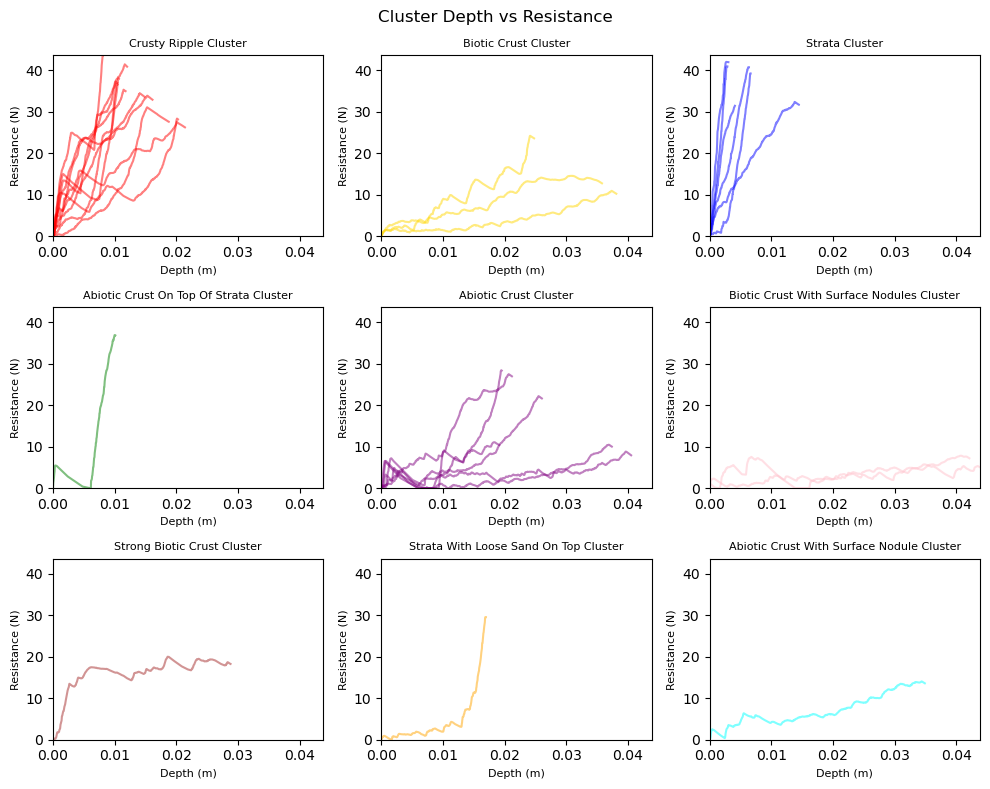

In [257]:
feifeis_features_df = data_features_df[data_features_df['feifeis_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
# encodes object into categorical variables
feifeis_features_df['encoded'], uniques = pd.factorize(feifeis_features_df['feifeis_ylabels'])
y_labels = feifeis_features_df['encoded'].to_list()
# plot_clusters_together(y_labels, feifeis_features_df.index)
plot_clusters_seperately(y_labels, feifeis_features_df.index, cluster_category_names=uniques.to_list(), filenames=False)

# Clustering Liam's Labels

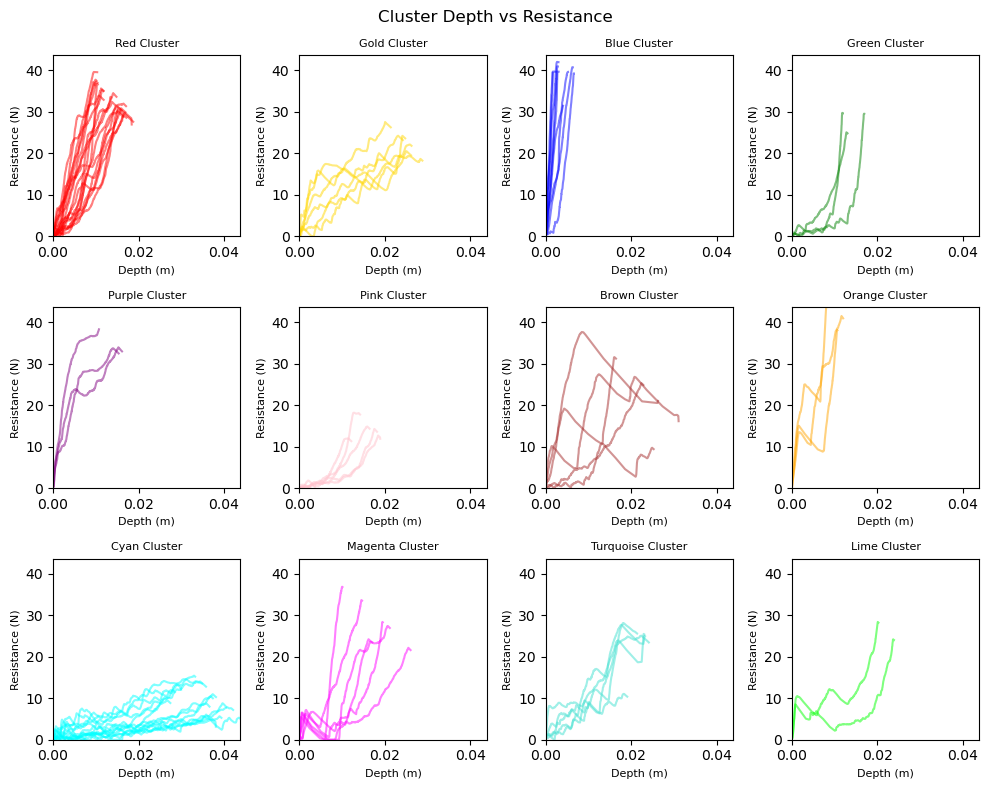

In [258]:
# plot_clusters_together(y_labels=data_features_df['liams_ylabels'])
plot_clusters_seperately(y_labels=data_features_df['liams_ylabels'], after_mask_indicies=data_features_df.index.tolist())

# Clustering Marion's Labels

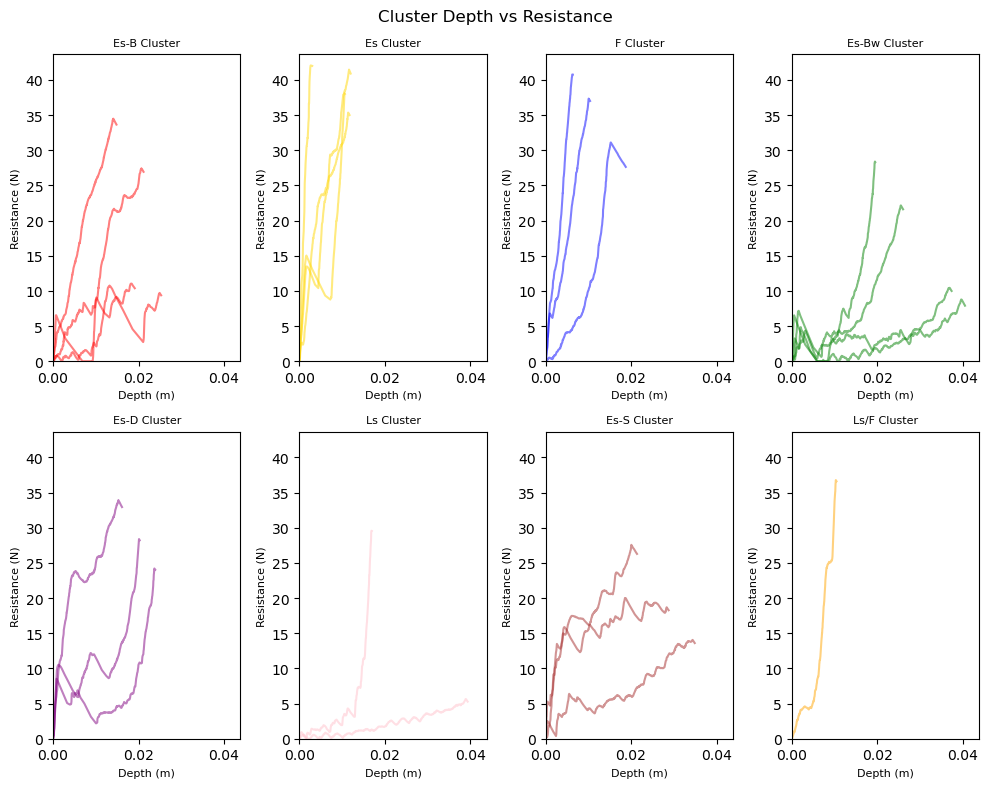

In [259]:
marions_features_df = data_features_df[data_features_df['marions_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
# print(marions_features_df)
# encodes object into categorical variables
marions_features_df['encoded'], uniques = pd.factorize(marions_features_df['marions_ylabels'])
# plot_clusters_together(y_labels=marions_features_df['encoded'])
plot_clusters_seperately(y_labels=marions_features_df['encoded'].tolist(), after_mask_indicies=marions_features_df.index.tolist(),
                         cluster_category_names=uniques.tolist())

# K-Means Clustering Implementation w/ k-means++ initialization for centroids

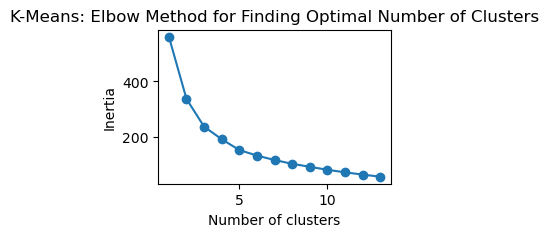

In [260]:
inertias = []
for k in range(1,14):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(clustering_features_df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(3,2))
plt.plot(range(1,14), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# K-Means Clustering
- assumes
    - spherical clusters (isotropic)
    - similar size clusters (equal variance)
    - features are on same scale
    - clusters are linearly separable
    - number of clusters (k) is known

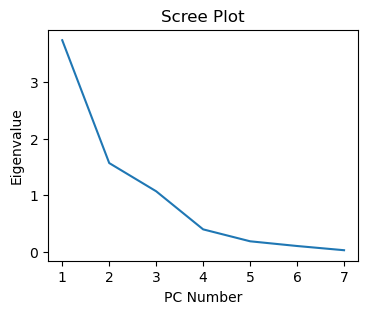

    Eigenvalue  Proportion  Cumulative
PC                                    
1     3.738091    0.527338    0.527338
2     1.568107    0.221215    0.748553
3     1.069265    0.150843    0.899396
4     0.396571    0.055945    0.955340
5     0.185869    0.026221    0.981561
6     0.102592    0.014473    0.996034
7     0.028113    0.003966    1.000000


                               PC1       PC2       PC3       PC4       PC5  \
overall_slope             0.493297  0.175699 -0.034518  0.264388  0.213775   
max_depth                -0.487701 -0.113722  0.156025 -0.164036 -0.403921   
max_resistance            0.467464  0.233111  0.092088  0.303017 -0.352483   
num_peaks                -0.419241 -0.184284 -0.104383  0.836118  0.256231   
largest_force_drop       -0.240212  0.665743 -0.124493  0.224039 -0.506084   
curve_shape              -0.005474  0.020544  0.966734  0.141218  0.025904   
largest_force_drop_level -0.258436  0.651353  0.070814 -0.205287  0.586904   

                      

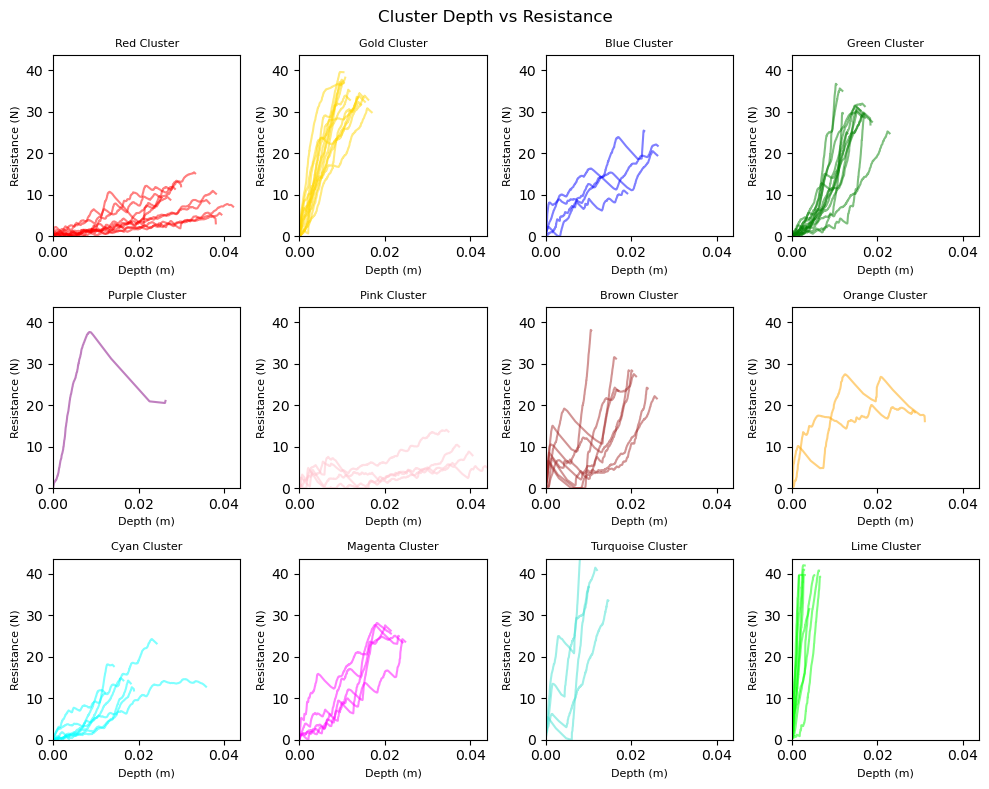

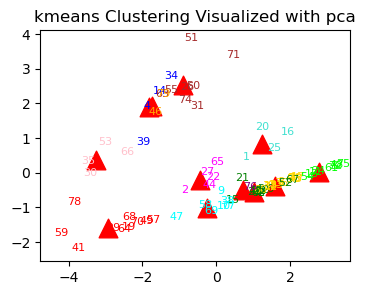

In [267]:
kmeans_elbow = 12
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(clustering_features_df)
# print(f"kmeans cluster centers: {kmeans.cluster_centers_}")
pca_analysis(clustering_features_df) # printing scree plot
# plot_clusters_together(kmeans.labels_, "kmeans")
plot_clusters_seperately(kmeans.labels_, clustering_features_df.index.tolist(), "kmeans")
plot_pca(clustering_features_df, y_labels=kmeans.labels_, graph_title="kmeans", kmeans_centroids=kmeans.cluster_centers_)

# Hierarchical Clustering

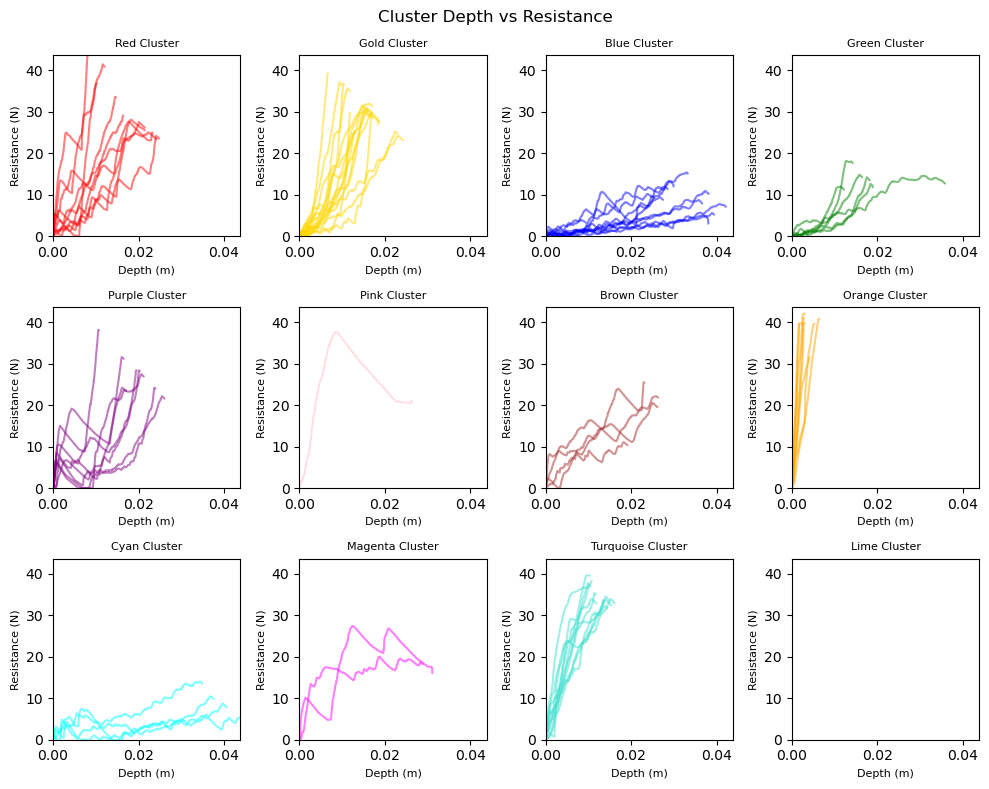

In [268]:

# if distance_threshold != None then n_clusters = None
hierarchical = AgglomerativeClustering(distance_threshold=None, n_clusters=11)
hierarchical.fit(clustering_features_df)
linkage = "Ward"
plot_clusters_seperately(hierarchical.labels_, clustering_features_df.index.tolist())

# DBSCAN

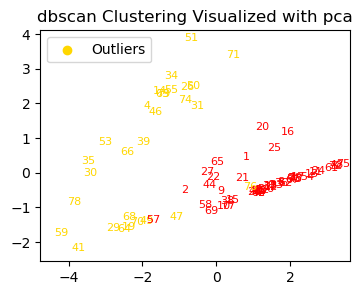

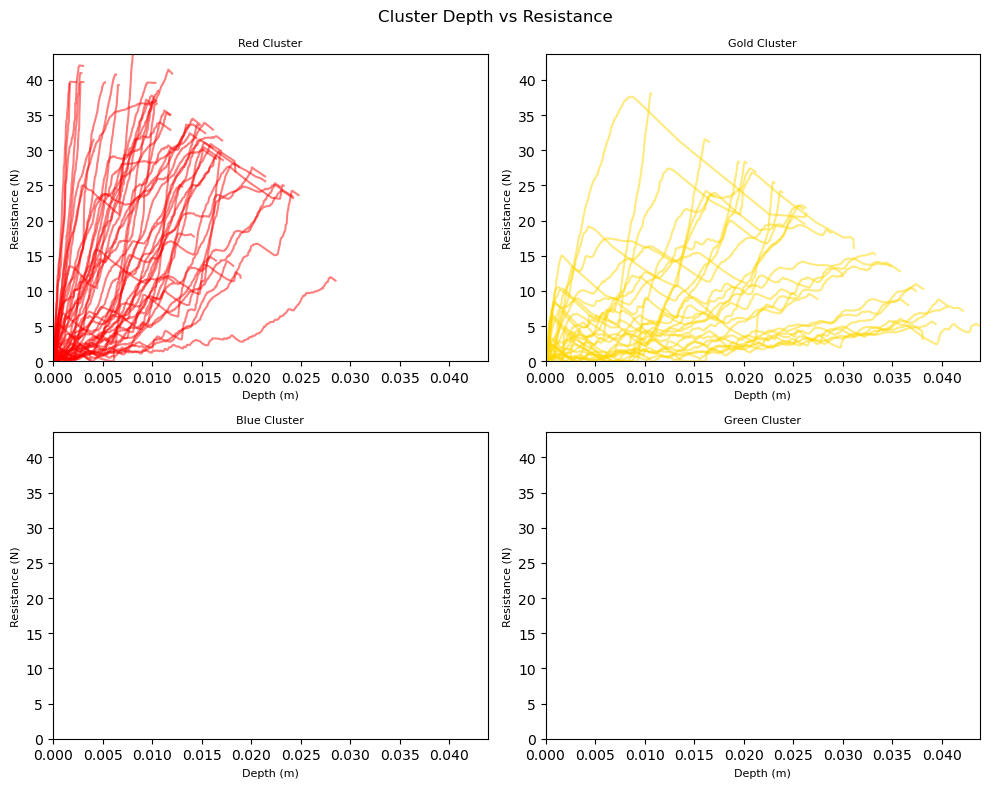

In [269]:

# eps=0.7, min_samples=3 works very well
dbscan = DBSCAN(eps=1.8, min_samples=10).fit(clustering_features_df)
cleaned_db_labels = [label if label != -1 else max(dbscan.labels_)+1 for label in dbscan.labels_]
# get_curve_idx_from_cluster_color("yellow", cleaned_db_labels)
plot_pca(clustering_features_df, cleaned_db_labels, 'dbscan')
plot_clusters_seperately(cleaned_db_labels, clustering_features_df.index.to_list())